# This is solution for the Problem2 of the below paper(link is given below)
"A spectral element method for solving the Pennes bioheat transfer equation by using triangular and quadrilateral elements"
https://www.sciencedirect.com/science/article/pii/S0307904X12000339#s0050

In the paper they have used SPECTRAL ELEMENGT METHOD for solving the problem but I have done using the recent application of Machine Learning - PINN(Physics infromed Neuaral Network).
The results have been compared in the different plots. I have created some extra plots for analyisng the temperature distribution in the tissue

In [1]:
import matplotlib.pyplot as plt



In [2]:
pip install pyDOE

Note: you may need to restart the kernel to use updated packages.


# All constants
Assumption : tissue as a single layer(l1) of same depth

In [3]:
# time for the simulation

sim_time = 100 # seconds

#shape of the tissue

length = 0.017 # m
depth = 0.017 # m

#for layer 
u_a = 37 # initial temp (deg C)
l1 = 0.017 # thickness of the layer(m)
rho1 = 1000 # density of the layer (kg/m^3)
rhob = 1000 # density of the blood vessel (kg/m^3)
C1 = 4000 # specific heat (J/kg. deg Celsius)
Cb1 = 4000 # specific heat of the blood (J/kg. deg Celsius)
K1 = 0.5 # thermal conductivity of the tissue (W/m. deg Celsius)
Wb1 = 0.0005 # Blood perfusion rate (m^3/s/m^3)
Q1 = lambda t,x1,x2 : -3998000*torch.exp(-t)*(torch.cos(torch.pi*x1)+torch.sin(torch.pi*x2))+ (1/2)*torch.exp(-t)*torch.cos(torch.pi*x1)*torch.pi**2+2*torch.tanh(x1+x2)*(1-torch.tanh(x1+x2)**2)+ (1/2)*torch.exp(-t)*torch.sin(torch.pi*x2)*torch.pi**2+2000*torch.tanh(x1+x2)-420 #Volumetric heat due to spatial heating

Qm = 420 # metabolic heat in the tissue(W/m3)

u_analytical = lambda t,x1,x2 : torch.exp(-t)*(torch.cos(torch.pi*x1)+torch.sin(torch.pi*x2))+torch.tanh(x1+x2)+37






Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)
model parameters on gpu: False
Epoch (Adam): 0, Cost: 12469.5546875, Bound_loss: 2739.75390625, Fun_loss: 8285.51171875, Ini_loss: 1444.2891845703125
Epoch (Adam): 100, Cost: 4798.0419921875, Bound_loss: 2836.436767578125, Fun_loss: 533.0764770507812, Ini_loss: 1428.528564453125
Epoch (Adam): 200, Cost: 4302.2626953125, Bound_loss: 2705.430908203125, Fun_loss: 202.60353088378906, Ini_loss: 1394.228271484375
Epoch (Adam): 300, Cost: 3907.748291015625, Bound_loss: 2522.629150390625, Fun_loss: 64.88397216796875, Ini_loss: 1320.2349853515625
Epoch (Adam): 400, Cost: 3603.527099609375, Bound_loss: 2329.778076171875, Fun_loss: 52.1950302124

Epoch (Adam): 5800, Cost: 0.13739493489265442, Bound_loss: 0.05447791516780853, Fun_loss: 0.08271977305412292, Ini_loss: 0.00019724888261407614
Epoch (Adam): 5900, Cost: 0.31936168670654297, Bound_loss: 0.0512143075466156, Fun_loss: 0.2680608034133911, Ini_loss: 8.658692968310788e-05
Epoch (Adam): 6000, Cost: 0.11627912521362305, Bound_loss: 0.045772846788167953, Fun_loss: 0.07042279839515686, Ini_loss: 8.348288247361779e-05
Epoch (Adam): 6100, Cost: 0.10705041140317917, Bound_loss: 0.041877251118421555, Fun_loss: 0.0651128739118576, Ini_loss: 6.028459029039368e-05
Epoch (Adam): 6200, Cost: 0.10018941760063171, Bound_loss: 0.038602784276008606, Fun_loss: 0.06154586374759674, Ini_loss: 4.077460107509978e-05
Epoch (Adam): 6300, Cost: 0.09131456911563873, Bound_loss: 0.03511327505111694, Fun_loss: 0.05616486817598343, Ini_loss: 3.6423651181394234e-05
Epoch (Adam): 6400, Cost: 3.1257269382476807, Bound_loss: 0.03258761391043663, Fun_loss: 3.0931079387664795, Ini_loss: 3.137607200187631e-05

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


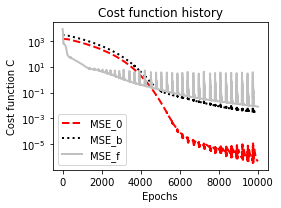

In [4]:
import time
import torch
import numpy as np
import scipy.io
from pyDOE import lhs
from physicsinformed import PhysicsInformedContinuous
from scipy.interpolate import griddata
import utilities

# Select gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(450)
np.random.seed(450) 

# Define no. of training points
N0 = 400 # intial values at t = 0 (0,x,z)
N_b = 500
N_f = 20000

# Define feed-forward network architecture
layers = [3, 20, 20, 20, 20, 1]

# Define no. of epochs for each optimizer
epochs_Adam = 8000
epochs_LBFGS = 1000

# Domain bounds
lb = np.array([0,0,0])  # minimum(t,x,z)
ub = np.array([sim_time,length,depth]) # maximum(t,x,z)

#lic  = [l1,(l1+l2),(l1+l2+l3)] #layer_interface_coordinates


# Create collocation points with latin hypercube sampling
txz_f = lb + (ub - lb) * lhs(3, N_f) # Creates 20000 sample points in x, y, z and t


# Transform grid into vectors that can be processed by the neural net
'''X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) #Stack arrays in sequence horizontally (column wise)
u_star = u_sol.flatten()[:, None]
flux_star = flux_sol.flatten()[:, None]
'''

# Select random data points for the initial condition
id_rand = np.random.choice(txz_f.shape[0], N0, replace=False) # Choose random 100 indices from 256 total indices of space
x0 = txz_f[:,1:2][id_rand, :] # location of these 100 random points
id_rand1 = np.random.choice(txz_f.shape[0], N0, replace=False)
z0 = txz_f[:,2:3][id_rand1, :]
xz0 = np.concatenate((0 * x0, x0, z0), 1) # (0,x0,z0) initial condition

# Select random data points for the boundary condition

# for z= 0 => (t,x,0)
id_tb = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random 50 indices from 201 total indices of time
tb = txz_f[:,0:1][id_tb, :] # time stamps of those 50 indices
id_xb = np.random.choice(txz_f.shape[0], N_b, replace=False)
xb = txz_f[:,1:2][id_xb, :]

tx0b = np.concatenate((tb, xb, 0*tb), 1)  # for calculating error for this cond>>add error term 3times for
                                               # 3 layers with different parameters

    
# for the lateral surfaces (boundary conditions)

# x-z plane -> ((t,x,y_lb,z) & (t,x,y_ub,z))
#coordinates for lateral surfaces

id_t_surface1 = np.random.choice(txz_f.shape[0], N_b, replace=False)
t_xz_ = txz_f[:,0:1][id_t_surface1, :]
id_x_surface2 = np.random.choice(txz_f.shape[0], N_b, replace=False) 
x_xz_ = txz_f[:,1:2][id_x_surface2, :]
id_z_surface3 = np.random.choice(txz_f.shape[0], N_b, replace=False)
z_xz_ = txz_f[:,2:3][id_z_surface3, :]

xz_lb = np.concatenate((t_xz_, x_xz_ , z_xz_ ), 1) # (t,x,z)  


## input data for the bottom (@ z = depth)

id_t_int = np.random.choice(txz_f.shape[0], N_b, replace=False) # Choose random N_b indices from 20000 total indices 
t_int_ = txz_f[:,0:1][id_t_int, :] # time stamps of those N_b indices
id_x_int = np.random.choice(txz_f.shape[0], N_b, replace=False)
x_int_ = txz_f[:,1:2][id_x_int, :]

txz_int_l3 = np.concatenate((t_int_, x_int_, 0 * t_int_ + depth ), 1)


### TRAINING ###
# Create torch.tensors of training data

#for the initial condition at t=0 # we will have to consider all 3 layers if assumption is removed

t_0 = torch.tensor(xz0[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_0 = torch.tensor(xz0[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_0 = torch.tensor(xz0[:, 2:3], dtype=dtype, requires_grad=True, device=device)

#for the surface boundary condition -> z=0

t_b = torch.tensor(tx0b[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_b = torch.tensor(tx0b[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_b = torch.tensor(tx0b[:, 2:3], dtype=dtype, requires_grad=True, device=device)


#for the lateral boundary condition -> lateral surafces x-z and y-z planes # we need to consider all 3 layers if assumption is removed

t_xz_lb = torch.tensor(xz_lb[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_xz_lb = torch.tensor(xz_lb[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_xz_lb = torch.tensor(xz_lb[:, 2:3], dtype=dtype, requires_grad=True, device=device)

# for the interfaces between the layers (@ l1 ,@ l1+l2 ,@ l1+l2+l3) but for our assumption we take single layer

t_int = torch.tensor(t_int_, dtype=dtype, requires_grad=True, device=device)
x_int = torch.tensor(x_int_, dtype=dtype, requires_grad=True, device=device)

#for layer 3 (if we consider only single layer, this z will be used for training)

z_int_l3 = torch.tensor(0 * t_int_ + depth , dtype=dtype, requires_grad=True, device=device)

# for the functional error
t_f = torch.tensor(txz_f[:, 0:1], dtype=dtype, requires_grad=True, device=device)
x_f = torch.tensor(txz_f[:, 1:2], dtype=dtype, requires_grad=True, device=device)
z_f = torch.tensor(txz_f[:, 2:3], dtype=dtype, requires_grad=True, device=device)

# Initialize PINN model
PINNModel = PhysicsInformedContinuous(layers, t_0,x_0,z_0, t_b, x_b, z_b, t_xz_lb,x_xz_lb,z_xz_lb, t_int, x_int, z_int_l3, t_f, x_f, z_f,u_a, Q1,Qm)

# Train the model
start_time = time.time()
PINNModel.train(10000, optimizer='Adam', lr=0.001)
#PINNModel.train(epochs_LBFGS, optimizer='L-BFGS')
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


# Plot training history and predicitons
PINNModel.plot_training_history()

## Comparison of the results for Temperature distribution vs time
By using theh analytical solution provided in the paper, I have compared the results of the PINN.
Both the lines are almost overlapping

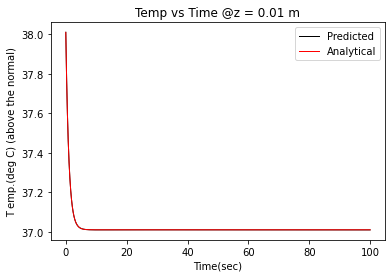

In [5]:
n = 1500
x_star = torch.tensor(np.array([np.linspace(0,length,n)]).T, dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(np.array([np.linspace(0,depth,n)]).T, dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(np.array([np.linspace(0,sim_time,n)]).T, dtype=dtype, requires_grad=True, device=device)
T_orig = u_analytical(t_star,z_star*0+0.010,x_star*0)
T1 = PINNModel.u_nn(t_star, z_star*0+0.010,x_star*0).detach().cpu().numpy().T[0]
x = x_star.detach().cpu().numpy().T[0]
z = z_star.detach().cpu().numpy().T[0]
t = t_star.detach().cpu().numpy().T[0]
T_orig = T_orig.detach().cpu().numpy().T[0]
plt.xlabel('Time(sec)')
plt.ylabel('T emp.(deg C) (above the normal)')
p1 = plt.plot(t,T1,color='black', linewidth=1)
p2 = plt.plot(t,T_orig,color='red', linewidth=1)
plt.title('Temp vs Time @z = 0.01 m')
plt.legend(['Predicted','Analytical'], loc='upper right')

## Comparison of Temp vs depth after 150 sec; is compared with the analytical solution

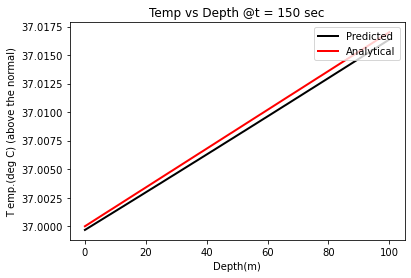

In [6]:
n = 1500
x_star = torch.tensor(np.array([np.linspace(0,length,n)]).T, dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(np.array([np.linspace(0,depth,n)]).T, dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(np.array([np.linspace(0,sim_time,n)]).T, dtype=dtype, requires_grad=True, device=device)
T_orig = u_analytical(t_star*0+100,z_star,x_star*0)
T1 = PINNModel.u_nn(t_star*0+100, z_star,x_star*0).detach().cpu().numpy().T[0]
x = x_star.detach().cpu().numpy().T[0]
z = z_star.detach().cpu().numpy().T[0]
t = t_star.detach().cpu().numpy().T[0]
T_orig = T_orig.detach().cpu().numpy().T[0]
plt.xlabel('Depth(m)')
plt.ylabel('T emp.(deg C) (above the normal)')
p1 = plt.plot(t,T1,color='black', linewidth=2)
p2 = plt.plot(t,T_orig,color='red', linewidth=2)
plt.title('Temp vs Depth @t = 150 sec')
plt.legend(['Predicted','Analytical'], loc='upper right')

# Below are the two temperature gradient graphs for comparison
first one is the reslut of the PINN model and the second one is result of the analytical solution

/Users/ashutosh/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/fl/ftz0f2rj0bbg270g60kbg5wc0000gn/T/ipykernel_89919/1748535559.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_star = torch.tensor(torch.reshape(x,(x.shape[0],1)), dtype=dtype, requires_grad=True, device=device)
/var/folders/fl/ftz0f2rj0bbg270g60kbg5wc0000gn/T/ipykernel_89919/1748535559.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

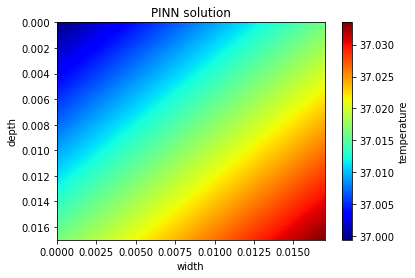

In [7]:
n = 1000

x,z = torch.meshgrid(torch.linspace(0,length,n),torch.linspace(0,depth,n))
x = torch.flatten(x)
z = torch.flatten(z)

x_star = torch.tensor(torch.reshape(x,(x.shape[0],1)), dtype=dtype, requires_grad=True, device=device)
z_star = torch.tensor(torch.reshape(z,(z.shape[0],1)), dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(torch.tensor(z)*0+150, dtype=dtype, requires_grad=True, device=device)


T1 = PINNModel.u_nn(z_star*0+150, z_star,x_star).detach().cpu().numpy().T[0]

T_orig = u_analytical(z*0+150,z,x)

plt.figure()
plt.imshow(T1.reshape(1000,1000),cmap='jet',extent=[min(x),max(x),max(z),min(z)],aspect='auto')
plt.ylabel('depth')
plt.xlabel('width')
plt.colorbar(label='temperature')
plt.title('PINN solution')
plt.show()


In [8]:
u_analytical(torch.tensor(150),torch.tensor(0.0),torch.tensor(0.015))

tensor(37.0150)

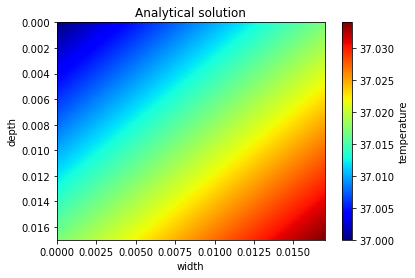

In [9]:
plt.figure()
plt.imshow(T_orig.reshape(1000,1000),cmap='jet',extent=[min(x),max(x),max(z),min(z)],aspect='auto')
plt.ylabel('depth')
plt.xlabel('width')
plt.colorbar(label='temperature')
plt.title('Analytical solution')
plt.show()

In [13]:
error1 = []
time = [i for i in range(1,101)]
for j in time:
    T1 = PINNModel.u_nn(z_star*0+j, z_star,x_star).detach().cpu().numpy().T[0]
    T_orig = u_analytical(z*0+j,z,x)
    error1.append((torch.mean(((T_orig-T1)/T_orig)**2))**0.5)

In [14]:
error = []
time = [i for i in range(1,101)]
for j in time:
    T1 = PINNModel.u_nn(z_star*0+j, z_star,x_star).detach().cpu().numpy().T[0]
    T_orig = u_analytical(z*0+j,z,x)
    error.append((torch.mean(((T_orig-T1)/T_orig)**2))**0.5)
'''plt.plot(time,error)   
plt.xlabel('time')
plt.ylabel('RMS Relative Error')
plt.title('Error Analysis')'''

"plt.plot(time,error)   \nplt.xlabel('time')\nplt.ylabel('RMS Relative Error')\nplt.title('Error Analysis')"

# this plot shows the RMS(root mean square of the errors in solution of the PINN and the analytical solution from t =0 to t = 100 s

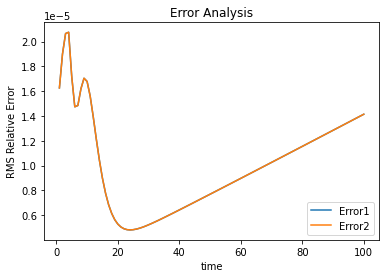

In [15]:
plt.plot(time,error1)  
plt.plot(time,error)   
plt.xlabel('time')
plt.ylabel('RMS Relative Error')
plt.title('Error Analysis')
plt.legend(['Error1','Error2'], loc='lower right')